In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix

import string
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout

import nltk
nltk.download('stopwords')

import warnings
warnings.filterwarnings('ignore')

import pickle

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
data = pd.read_csv("/content/drive/MyDrive/archive/Reviews.csv")
data.head(10)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
5,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,4,1342051200,Nice Taffy,I got a wild hair for taffy and ordered this f...
6,7,B006K2ZZ7K,A1SP2KVKFXXRU1,David C. Sullivan,0,0,5,1340150400,Great! Just as good as the expensive brands!,This saltwater taffy had great flavors and was...
7,8,B006K2ZZ7K,A3JRGQVEQN31IQ,Pamela G. Williams,0,0,5,1336003200,"Wonderful, tasty taffy",This taffy is so good. It is very soft and ch...
8,9,B000E7L2R4,A1MZYO9TZK0BBI,R. James,1,1,5,1322006400,Yay Barley,Right now I'm mostly just sprouting this so my...
9,10,B00171APVA,A21BT40VZCCYT4,Carol A. Reed,0,0,5,1351209600,Healthy Dog Food,This is a very healthy dog food. Good for thei...


In [ ]:
data.shape

(568454, 10)

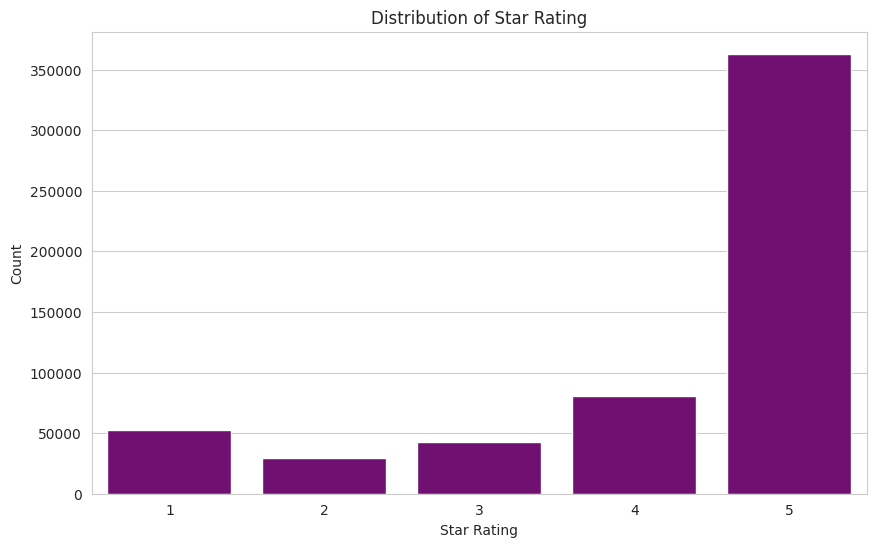

In [ ]:
data.columns.values.tolist()

score_counts = data['Score'].value_counts().sort_index()
sns.set_style("whitegrid")

plt.figure(figsize = (10,6))
sns.barplot(x=score_counts.index, y=score_counts.values, color = 'purple')
plt.xlabel('Star Rating')
plt.ylabel('Count')
plt.title('Distribution of Star Rating')
plt.show()

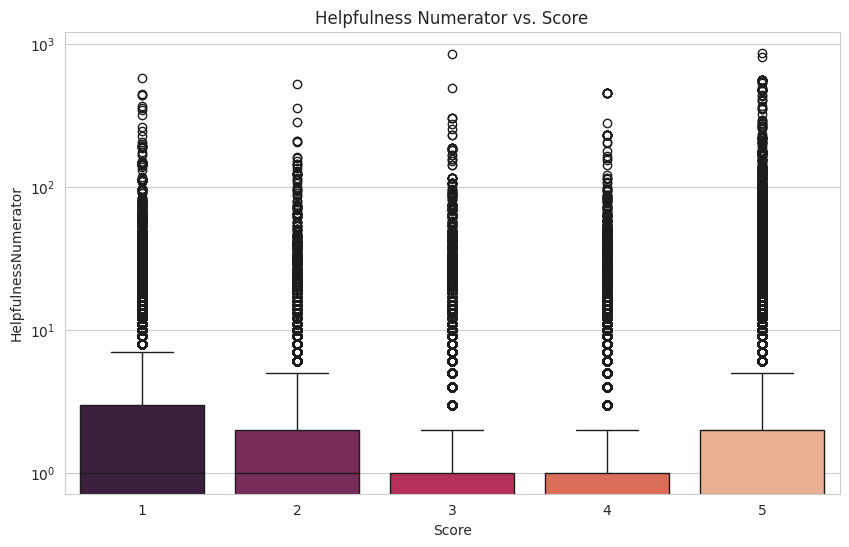

In [ ]:
# 5. Relationship between Helpfulness and Score
plt.figure(figsize=(10, 6))
sns.boxplot(x='Score', y='HelpfulnessNumerator', data=data, palette="rocket")
plt.yscale("log")  # Log scale for better visibility of variations
plt.title("Helpfulness Numerator vs. Score")
plt.show()


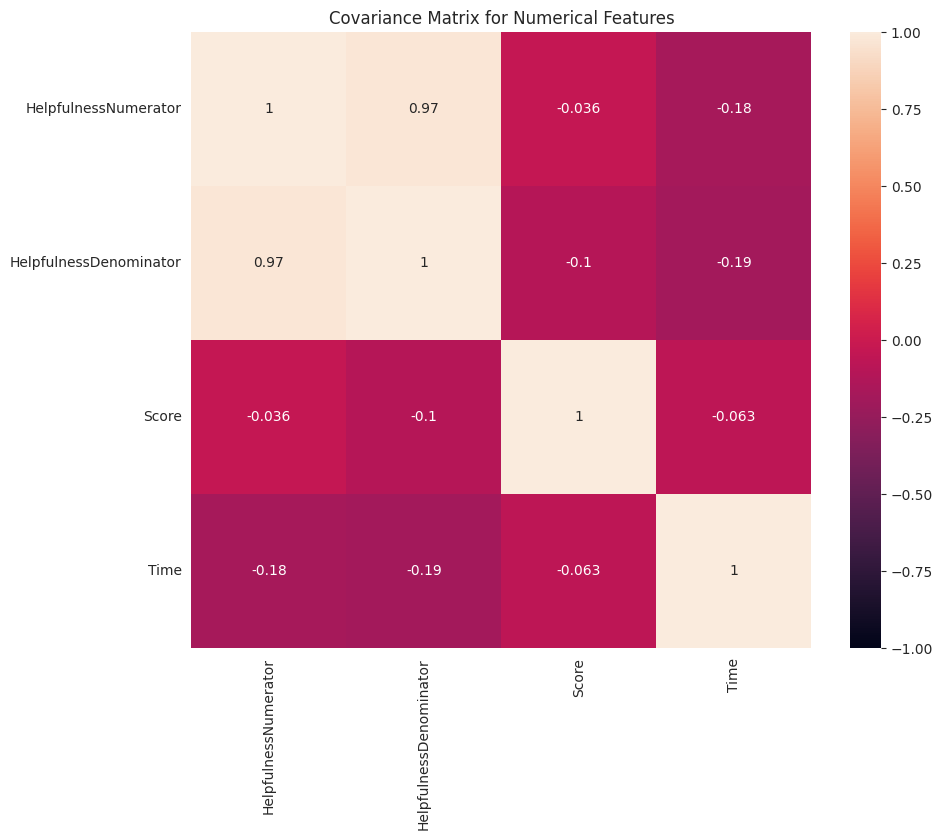

In [ ]:
# 6. Covariance Matrix for Numerical Features
plt.figure(figsize=(10, 8))
sns.heatmap(data[['HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time']].corr(),
            annot=True, cmap="rocket", vmin=-1, vmax=1)
plt.title("Covariance Matrix for Numerical Features")
plt.show()

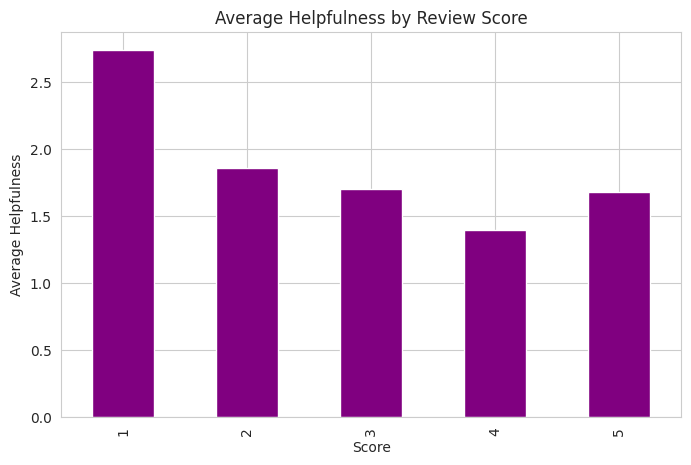

In [ ]:
helpfulness_by_score = data.groupby('Score')['HelpfulnessNumerator'].mean()

plt.figure(figsize=(8, 5))
helpfulness_by_score.plot(kind='bar', color='purple')
plt.title("Average Helpfulness by Review Score")
plt.xlabel("Score")
plt.ylabel("Average Helpfulness")
plt.show()

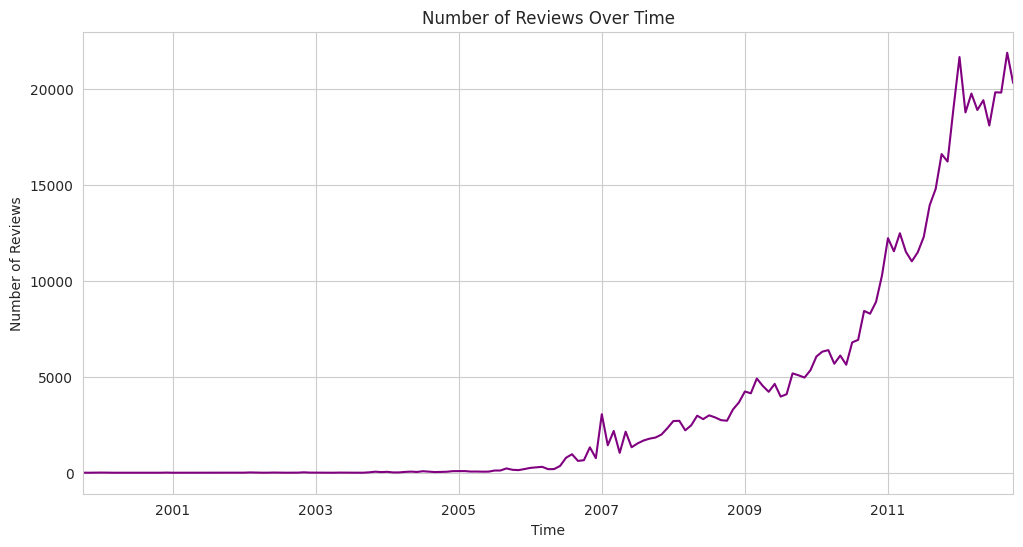

In [ ]:
data['ReviewTime'] = pd.to_datetime(data['Time'], unit='s')
reviews_over_time = data.set_index('ReviewTime').resample('M').size()

plt.figure(figsize=(12, 6))
reviews_over_time.plot(color='purple')
plt.title("Number of Reviews Over Time")
plt.xlabel("Time")
plt.ylabel("Number of Reviews")
plt.show()

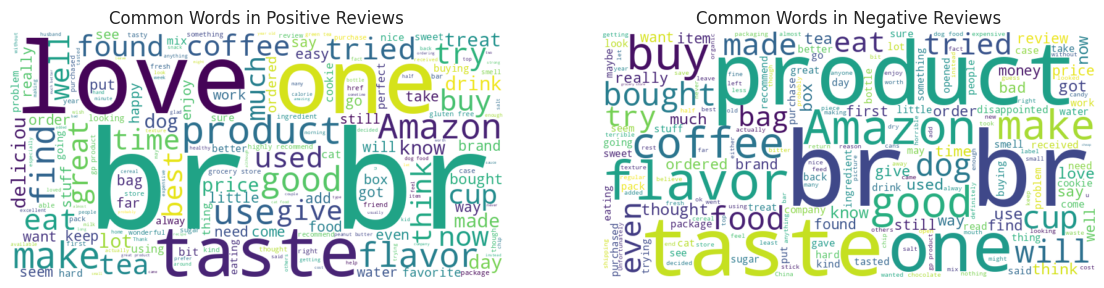

In [ ]:
# 4. Word Cloud for Positive vs. Negative Reviews
# Identifies common words in positive and negative reviews, providing sentiment insight on product perception
positive_reviews = " ".join(data[data['Score'] >= 4]['Text'])
negative_reviews = " ".join(data[data['Score'] <= 2]['Text'])

plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
wordcloud_pos = WordCloud(width=800, height=400, background_color='white').generate(positive_reviews)
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.title("Common Words in Positive Reviews")

plt.subplot(1, 2, 2)
wordcloud_neg = WordCloud(width=800, height=400, background_color='white').generate(negative_reviews)
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')
plt.title("Common Words in Negative Reviews")
plt.show()

In [ ]:
# Check null values
data.isna().sum().to_frame(name='# of missing values')

,# of missing values
Id,0
ProductId,0
UserId,0
ProfileName,26
HelpfulnessNumerator,0
HelpfulnessDenominator,0
Score,0
Time,0
Summary,27
Text,0


In [ ]:
# # Step 2: Data Cleaning and Sampling - Detailed and Step-by-Step

# # Initial data shape before cleaning
# initial_shape = data.shape

# # 1. Handling Missing Values
# # Dropping rows with missing values in 'ProfileName' and 'Summary' columns
# data_dropped_na = data.dropna(subset=['ProfileName', 'Summary'])
# shape_after_dropping_na = data_dropped_na.shape

# # 2. Checking for Duplicate Records
# # Count duplicate records in data after removing rows with missing values
# duplicate_records_count = data_dropped_na.duplicated().sum()

# # Removing duplicates
# data_cleaned = data_dropped_na.drop_duplicates()
# shape_after_dropping_duplicates = data_cleaned.shape

# # Calculate the percentage of data remaining after each step
# percentage_remaining_after_na = (shape_after_dropping_na[0] / initial_shape[0]) * 100
# percentage_remaining_after_duplicates = (shape_after_dropping_duplicates[0] / initial_shape[0]) * 100

# # Results after each step
# initial_shape, shape_after_dropping_na, duplicate_records_count, shape_after_dropping_duplicates, percentage_remaining_after_na, percentage_remaining_after_duplicates


((568454, 10),
 (568401, 10),
 0,
 (568401, 10),
 99.99067646634556,
 99.99067646634556)

In [ ]:
total_rows =  data.shape[0]
data.dropna(how='any',inplace=True)
remaining_rows= data.shape[0]

removed_rows = total_rows-remaining_rows
print("No. of rows removed :", removed_rows)

print(f"\nPercentage of data removed:{np.round((removed_rows/total_rows)*100,2)}%")
print(f"Percentage of data remaining:{np.round((remaining_rows/total_rows)*100,2)}%")

No. of rows removed : 53

Percentage of data removed:0.01%
Percentage of data remaining:99.99%


In [ ]:
a =  data.shape[0]
data.drop_duplicates(inplace=True, subset=['Score','Text'])
b = data.shape[0]

print("No. of rows removed :", a-b)

print(f"\nPercentage of data removed: {np.round(((a-b)/total_rows)*100,2)}%")
print(f"Percentage of data remaining: {np.round((b/total_rows)*100,2)}%")

No. of rows removed : 174745

Percentage of data removed: 30.74%
Percentage of data remaining: 69.25%


In [ ]:
a =  data.shape[0]

idx = data[data["HelpfulnessNumerator"]>data["HelpfulnessDenominator"]].index
data.drop(index=idx, inplace=True)

b = data.shape[0]

print("No. of rows removed :", a-b)

print(f"\nPercentage of data removed:{np.round(((a-b)/total_rows)*100,2)}%")
print(f"Percentage of data remaining:{np.round((b/total_rows)*100,2)}%")

No. of rows removed : 2

Percentage of data removed:0.0%
Percentage of data remaining:69.25%


In [ ]:
## `Score` > 3 : "Positive"
## `Score` == 3 : "Neutral"
## `Score` < 3 : "Negative"

def create_target(x):

    return "Positive" if x>3 else "Negative" if x<3 else "Neutral"

data.loc[:, 'target'] = data.Score.apply(create_target)

In [ ]:
# target column
data[['Score', 'target']].sample(5)

,Score,target
76626,5,Positive
445633,5,Positive
551075,5,Positive
206597,1,Negative
63602,4,Positive


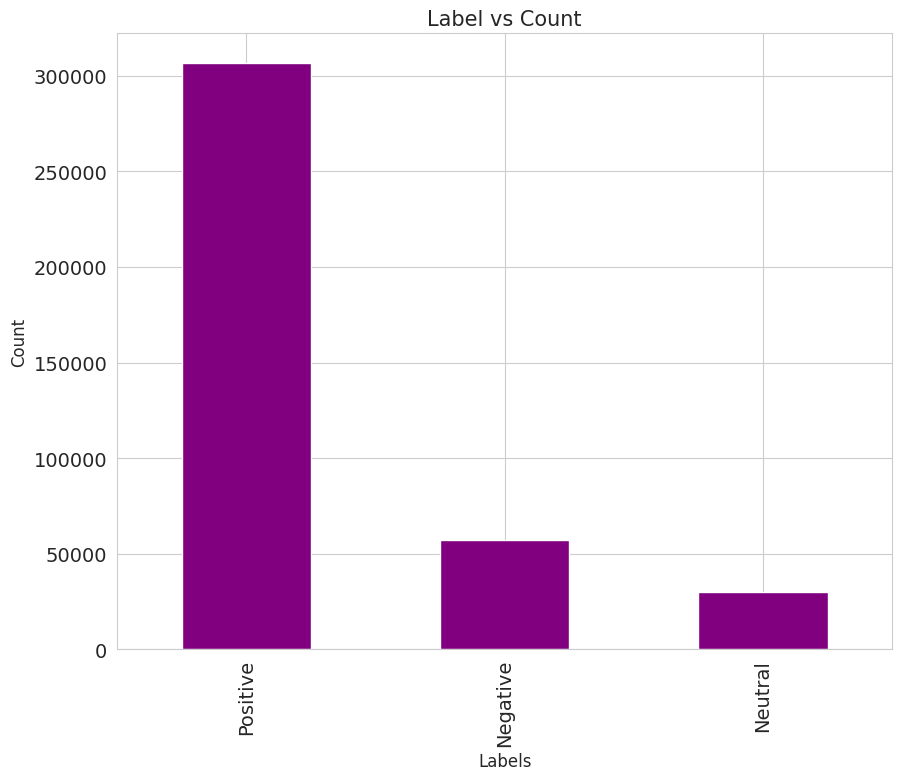

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

vc = data.target.value_counts()
vc.plot.bar(color="purple", fontsize=14, ax=ax)  # Changed 'barh' to 'bar'
ax.set_title("Label vs Count", fontsize=15)
ax.set_xlabel("Labels", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
plt.show()


In [ ]:
neutral = data.loc[data.target=="Neutral"] # 29770 reviews

positive = data.loc[data.target=="Positive"].sample(50000)

negative = data.loc[data.target=="Negative"].sample(50000)

data = pd.concat([positive, negative, neutral])
data.shape

(129770, 13)

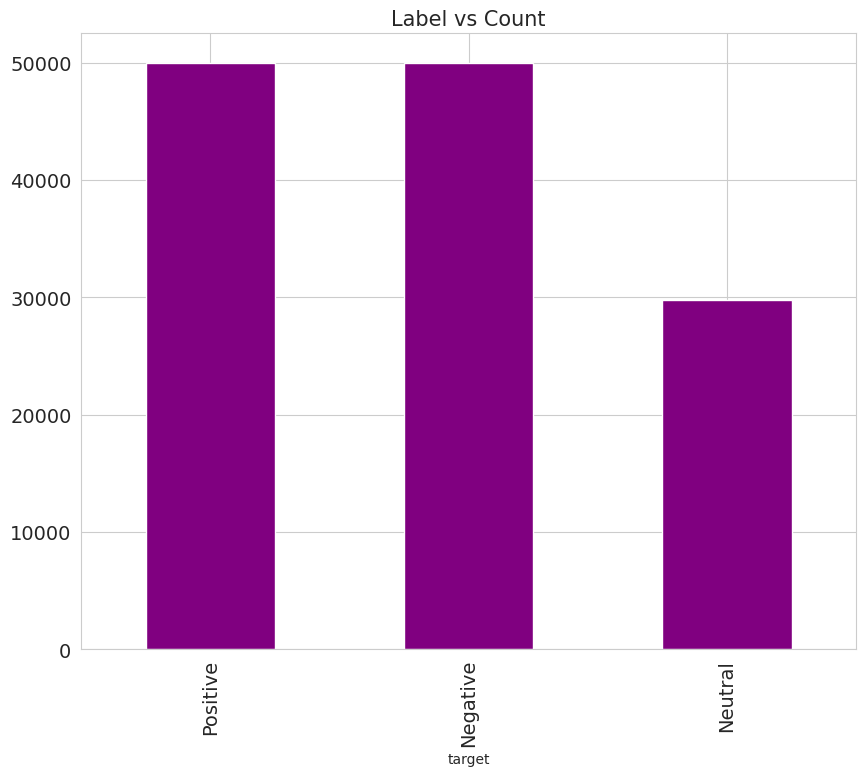

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

vc = data.target.value_counts()
vc.plot.bar(color="purple",fontsize=14,ax=ax)
ax.set_title("Label vs Count", fontsize=15)
plt.show()

In [ ]:
# stopwords
total_stopwords = set(stopwords.words('english'))

# subtract negative stop words like no, not, don't etc.. from total_stopwords
negative_stop_words = set(word for word in total_stopwords
                          if "n't" in word or 'no' in word)

final_stopwords = total_stopwords - negative_stop_words

#
final_stopwords.add("one")
print(final_stopwords)

{'didn', 'herself', 'than', 'isn', 'they', 'ours', 'itself', 'that', 'so', 'and', 'this', 'am', 'can', 'you', 'when', 'hasn', 'of', 'other', 'shouldn', 'having', 'whom', 's', 'with', 'couldn', 'why', 'same', 'shan', 'y', 'been', 'just', 'but', 'll', 'be', 'we', 'while', 'at', 'down', 'into', 'off', 'doing', 'who', 'our', 'where', 'did', 'her', 'should', 'needn', 'then', 'd', 'had', "she's", 'is', 'how', 'won', "you'd", 'or', 'out', 'me', 'these', 'there', 'through', "it's", 'don', 'by', 'himself', 'from', 'once', 'what', "you'll", 'mustn', 'such', 'hadn', 'as', 'doesn', 'my', 'during', 'again', 'yourselves', 'further', 'a', 'ourselves', 'ma', 'if', 'those', 'few', 'do', 'wouldn', 'below', 'up', 'being', 'against', 'yours', 'are', 'were', 'weren', 'was', 'too', 'most', 'very', 'ain', 'over', "you're", 'because', 'which', 'its', 'yourself', 'theirs', 'here', 'to', 'between', 'wasn', 'after', 'an', 'until', 'before', 'mightn', 'him', 'o', 'themselves', 'them', 'in', 'haven', 'will', 'aren

In [ ]:
#stemming object
stemmer = PorterStemmer()

# ---------------------------------------------
HTMLTAGS = re.compile('<.*?>')
table = str.maketrans(dict.fromkeys(string.punctuation))
remove_digits = str.maketrans('', '', string.digits)
MULTIPLE_WHITESPACE = re.compile(r"\s+")
# ---------------------------------------------

In [ ]:
def preprocessor(review):
    # remove html tags
    review = HTMLTAGS.sub(r'', review)

    # remove puncutuation
    review = review.translate(table)

    # remove digits
    review = review.translate(remove_digits)

    # lower case all letters
    review = review.lower()

    # replace multiple white spaces with single space
    review = MULTIPLE_WHITESPACE.sub(" ", review).strip()

    # remove stop words
    review = [word for word in review.split()
              if word not in final_stopwords]

    # stemming
    review = ' '.join([stemmer.stem(word) for word in review])

    return review

In [ ]:
print("Before preprocessing : ")
data.Text.iloc[6]

Before preprocessing : 


'I am a big time tea drinker, and I absolutely enjoyed this particular tea, which has an amazing taste. Enjoy!'

In [ ]:
# apply preprocessing function

data.Text = data.Text.apply(preprocessor)
print("After preprocessing : ")
data.Text.iloc[6]

After preprocessing : 


'big time tea drinker absolut enjoy particular tea amaz tast enjoy'

In [ ]:
def generate_wcloud(text):
    stopwords = set(STOPWORDS)

    wordcloud = WordCloud(stopwords=stopwords, background_color='white')
    wordcloud.generate(text)

    plt.figure(figsize=(15,7))
    plt.axis('off')
    plt.imshow(wordcloud, interpolation='bilinear')
    return plt.show()

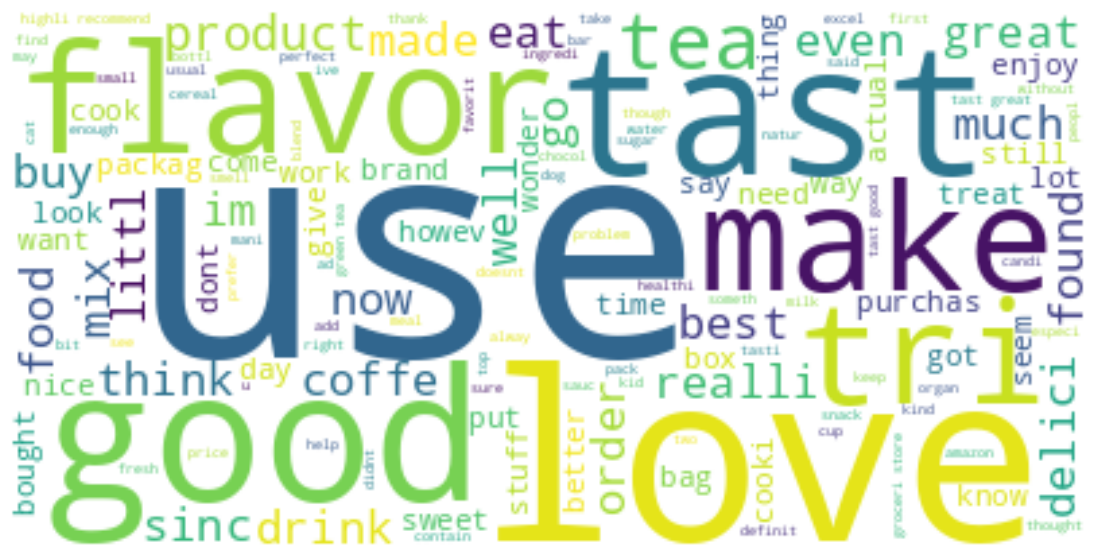

In [ ]:
pos = data.loc[data.target=="Positive"].Text
text = " ".join(review for review in pos.astype(str))

generate_wcloud(text)

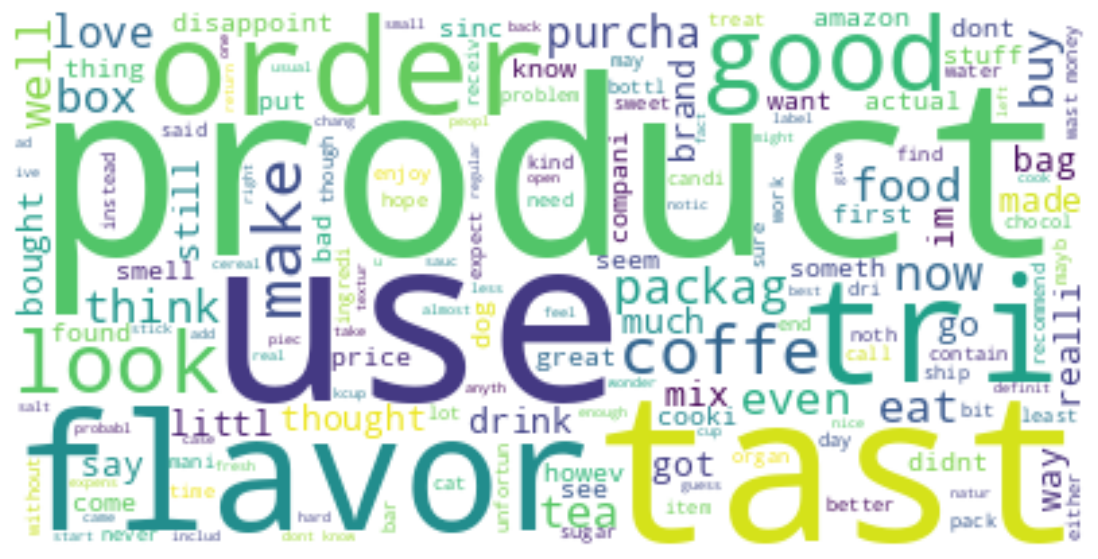

In [ ]:
pos = data.loc[data.target=="Negative"].Text
text = " ".join(review for review in pos.astype(str))

generate_wcloud(text)

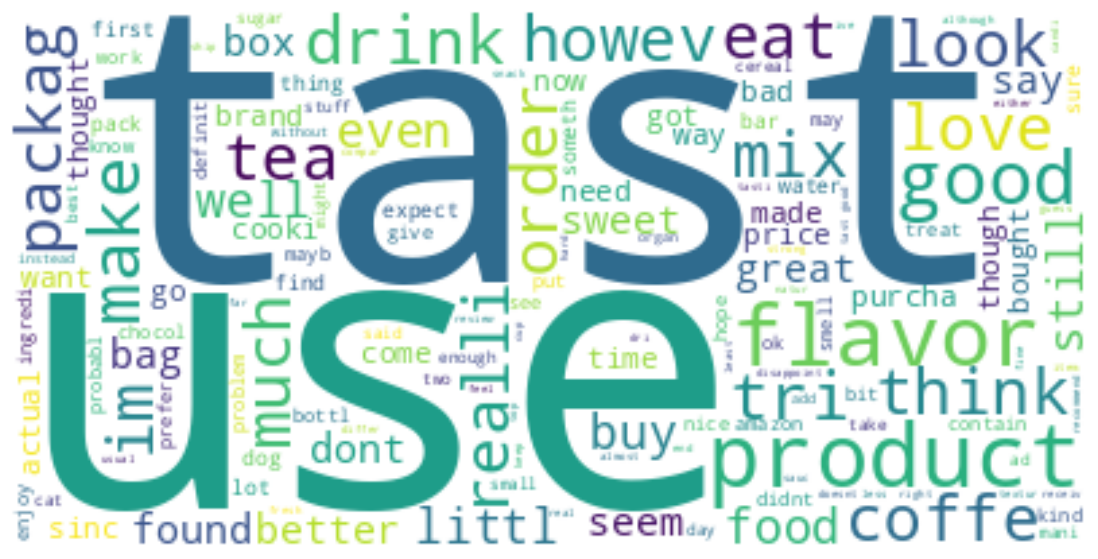

In [ ]:
pos = data.loc[data.target=="Neutral"].Text
text = " ".join(review for review in pos.astype(str))

generate_wcloud(text)

In [ ]:
X = data.Text
y = data.target

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.20, random_state=1, stratify=y)

In [ ]:
X_train.shape, X_test.shape

((454763,), (113691,))

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=1000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)


In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(n_estimators=50, max_depth=10, n_jobs=-1, random_state=42)
rf_classifier.fit(X_train_tfidf, y_train)


RandomForestClassifier(n_estimators=50, random_state=42)

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

y_pred = rf_classifier.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.8879858564002427

Classification Report:
               precision    recall  f1-score   support

    Negative       0.92      0.57      0.70     16407
     Neutral       0.98      0.39      0.56      8528
    Positive       0.88      0.99      0.94     88756

    accuracy                           0.89    113691
   macro avg       0.93      0.65      0.73    113691
weighted avg       0.89      0.89      0.87    113691



In [ ]:
bow_vectorizer = CountVectorizer(max_features=10000)
bow_vectorizer.fit(X_train)

# transform
bow_X_train = bow_vectorizer.transform(X_train)
bow_X_test = bow_vectorizer.transform(X_test)

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
tfidf_vectorizer.fit(X_train)

# transform
tfidf_X_train = tfidf_vectorizer.transform(X_train)
tfidf_X_test = tfidf_vectorizer.transform(X_test)

In [ ]:
labelEncoder = LabelEncoder()

y_train = labelEncoder.fit_transform(y_train)
y_test = labelEncoder.transform(y_test)

labels = labelEncoder.classes_.tolist()
print(labels) # index-> class

['Negative', 'Neutral', 'Positive']


In [ ]:
def train_and_eval(model, trainX, trainY, testX, testY):

    # training
    _ = model.fit(trainX, trainY)

    # predictions
    y_preds_train = model.predict(trainX)
    y_preds_test = model.predict(testX)

    # evaluation
    print()
    print(model)
    print(f"Train accuracy score : {accuracy_score(y_train, y_preds_train)}")
    print(f"Test accuracy score : {accuracy_score(y_test, y_preds_test)}")
    print('\n',40*'-')

In [ ]:
C = [0.001, 0.01, 0.1, 1, 10]

for c in C:
    # Define model
    log_model = LogisticRegression(C=c, max_iter=500, random_state=1)

    # Train and evaluate model
    train_and_eval(model=log_model,
                   trainX=bow_X_train,
                   trainY=y_train,
                   testX=bow_X_test,
                   testY=y_test)


LogisticRegression(C=0.001, max_iter=500, random_state=1)
Train accuracy score : 0.8497788958204603
Test accuracy score : 0.8475692886859998

 ----------------------------------------

LogisticRegression(C=0.01, max_iter=500, random_state=1)
Train accuracy score : 0.8727359085941468
Test accuracy score : 0.8668232313903476

 ----------------------------------------

LogisticRegression(C=0.1, max_iter=500, random_state=1)
Train accuracy score : 0.8867937804966542
Test accuracy score : 0.8756102066126606

 ----------------------------------------

LogisticRegression(C=1, max_iter=500, random_state=1)
Train accuracy score : 0.8900614166060123
Test accuracy score : 0.8765337625669578

 ----------------------------------------

LogisticRegression(C=10, max_iter=500, random_state=1)
Train accuracy score : 0.8905781692881787
Test accuracy score : 0.8763138682921251

 ----------------------------------------


In [ ]:
alphas = [0, 0.2, 0.6, 0.8, 1]

for a  in alphas:
    # Define model
    nb_model = MultinomialNB(alpha=a)

    # Train and evaluate model
    train_and_eval(model=nb_model,
                   trainX=bow_X_train,
                   trainY=y_train,
                   testX=bow_X_test,
                   testY=y_test)


MultinomialNB(alpha=0)
Train accuracy score : 0.8145253681587992
Test accuracy score : 0.81043354355226

 ----------------------------------------

MultinomialNB(alpha=0.2)
Train accuracy score : 0.8141713375978257
Test accuracy score : 0.8101432831094809

 ----------------------------------------

MultinomialNB(alpha=0.6)
Train accuracy score : 0.8139822281056286
Test accuracy score : 0.8101432831094809

 ----------------------------------------

MultinomialNB(alpha=0.8)
Train accuracy score : 0.8139272544160365
Test accuracy score : 0.8102136492774275

 ----------------------------------------

MultinomialNB(alpha=1)
Train accuracy score : 0.8137909196658479
Test accuracy score : 0.8100641211705412

 ----------------------------------------


In [ ]:
# Hyperparameters
C = [0.001, 0.01, 0.1, 1, 10]

for c in C:
    # Define model
    log_model = LogisticRegression(C=c, max_iter=500, random_state=1)

    # Train and evaluate model
    train_and_eval(model=log_model,
                   trainX=tfidf_X_train,
                   trainY=y_train,
                   testX=tfidf_X_test,
                   testY=y_test)


LogisticRegression(C=0.001, max_iter=500, random_state=1)
Train accuracy score : 0.7806923606361995
Test accuracy score : 0.780721429136871

 ----------------------------------------

LogisticRegression(C=0.01, max_iter=500, random_state=1)
Train accuracy score : 0.8256520429322526
Test accuracy score : 0.8254391288668408

 ----------------------------------------

LogisticRegression(C=0.1, max_iter=500, random_state=1)
Train accuracy score : 0.8673374922761966
Test accuracy score : 0.863964605817523

 ----------------------------------------

LogisticRegression(C=1, max_iter=500, random_state=1)
Train accuracy score : 0.8842737865657496
Test accuracy score : 0.8764106217730515

 ----------------------------------------

LogisticRegression(C=10, max_iter=500, random_state=1)
Train accuracy score : 0.8914555493740696
Test accuracy score : 0.878750296857271

 ----------------------------------------


In [ ]:
alphas = [0, 0.2, 0.6, 0.8, 1]

for a  in alphas:
    # Define model
    nb_model = MultinomialNB(alpha=a)

    # Train and evaluate model
    train_and_eval(model=nb_model,
                   trainX=tfidf_X_train,
                   trainY=y_train,
                   testX=tfidf_X_test,
                   testY=y_test)


MultinomialNB(alpha=0)
Train accuracy score : 0.8210540435347643
Test accuracy score : 0.818754342911928

 ----------------------------------------

MultinomialNB(alpha=0.2)
Train accuracy score : 0.820768180348885
Test accuracy score : 0.8184728782401421

 ----------------------------------------

MultinomialNB(alpha=0.6)
Train accuracy score : 0.8200205381704316
Test accuracy score : 0.8177340334767044

 ----------------------------------------

MultinomialNB(alpha=0.8)
Train accuracy score : 0.8196291255005355
Test accuracy score : 0.8174261814919387

 ----------------------------------------

MultinomialNB(alpha=1)
Train accuracy score : 0.8193278696815705
Test accuracy score : 0.817232674530086

 ----------------------------------------


In [ ]:
def plot_cm(y_true, y_pred):
    plt.figure(figsize=(6,6))

    cm = confusion_matrix(y_true, y_pred, normalize='true')

    sns.heatmap(
        cm, annot=True, cmap='Blues', cbar=False, fmt='.2f',
        xticklabels=labels, yticklabels=labels)

    return plt.show()

In [ ]:
bmodel = LogisticRegression(C=1, max_iter=500, random_state=1)
bmodel.fit(tfidf_X_train, y_train)

LogisticRegression(C=1, max_iter=500, random_state=1)

In [ ]:
# predictions
y_preds_train = bmodel.predict(tfidf_X_train)
y_preds_test = bmodel.predict(tfidf_X_test)

In [ ]:
print(f"Train accuracy score : {accuracy_score(y_train, y_preds_train)}")
print(f"Test accuracy score : {accuracy_score(y_test, y_preds_test)}")

Train accuracy score : 0.8842737865657496
Test accuracy score : 0.8764106217730515


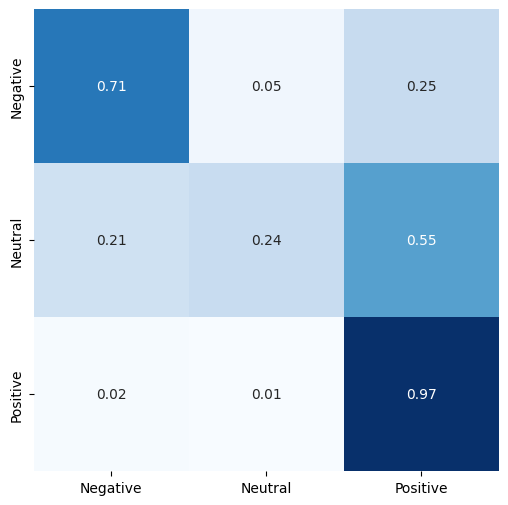

In [ ]:
plot_cm(y_test, y_preds_test)

In [ ]:
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer

# Define the preprocessor function
def preprocessor(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation (optional, based on your preprocessing needs)
    text = ''.join([char for char in text if char.isalnum() or char.isspace()])
    return text

# Load the saved TF-IDF vectorizer and model
with open("transformer.pkl", "rb") as f:
    tfidf_vectorizer = pickle.load(f)

with open("model.pkl", "rb") as f:
    bmodel = pickle.load(f)

# Define the function to get sentiment
labels = ['Negative', 'Neutral', 'Positive']
def get_sentiment(review):
    # Preprocessing
    x = preprocessor(review)
    # Vectorization
    x = tfidf_vectorizer.transform([x])
    # Prediction
    y = int(bmodel.predict(x))
    return labels[y]

# Test the function with a sample review
review = "This chips packet is very tasty. I highly recommend this!"
print(f"This is a {get_sentiment(review)} review!")


This is a Positive review!


In [ ]:
# positve review
review = "This chips packet is very tasty. I highly recommend this!"
print(f"This is a {get_sentiment(review)} review!")

This is a Positive review!


In [ ]:
# positve review
review = "This product is a waste of money. Don't buy this!!"
print(f"This is a {get_sentiment(review)} review!")

This is a Negative review!


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
import lightgbm as lgb
import pandas as pd

# Load and preprocess data (assuming data is already loaded into a DataFrame `data`)
def create_target(x):
    return "Positive" if x > 3 else "Negative" if x < 3 else "Neutral"

data['target'] = data['Score'].apply(create_target)
X = data['Text']
y = data['target']

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1, stratify=y)

# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))  # limit features for efficiency
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

lgb_preds = lgb_model.predict(X_test_tfidf)

# Print classification report
print("LightGBM Classification Report:\n", classification_report(y_test, lgb_preds))

# Calculate and print accuracy
accuracy = accuracy_score(y_test, lgb_preds)
print("LightGBM Accuracy:", accuracy)

LightGBM Classification Report:
               precision    recall  f1-score   support

    Negative       0.79      0.61      0.69     16407
     Neutral       0.65      0.19      0.30      8528
    Positive       0.88      0.98      0.93     88756

    accuracy                           0.87    113691
   macro avg       0.77      0.59      0.64    113691
weighted avg       0.85      0.87      0.85    113691

LightGBM Accuracy: 0.8685120194210624


In [7]:
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score

# Encode labels
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_test_enc = label_encoder.transform(y_test)

# Initialize the XGBoost model
xgb_model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train_tfidf, y_train_enc)

# Predictions and evaluation
xgb_preds = xgb_model.predict(X_test_tfidf)
print("XGBoost Classification Report:\n", classification_report(y_test_enc, xgb_preds, target_names=label_encoder.classes_))

# Calculate and print accuracy
xgb_accuracy = accuracy_score(y_test_enc, xgb_preds)
print("XGBoost Accuracy:", xgb_accuracy)

XGBoost Classification Report:
               precision    recall  f1-score   support

    Negative       0.85      0.39      0.54     16407
     Neutral       0.72      0.10      0.17      8528
    Positive       0.84      0.99      0.91     88756

    accuracy                           0.84    113691
   macro avg       0.81      0.49      0.54    113691
weighted avg       0.83      0.84      0.80    113691

XGBoost Accuracy: 0.8393892216622248


In [11]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout
from sklearn.preprocessing import LabelEncoder

# Load and preprocess data (assuming data is already loaded into a DataFrame `data`)
def create_target(x):
    return "Positive" if x > 3 else "Negative" if x < 3 else "Neutral"

data['target'] = data['Score'].apply(create_target)
X = data['Text']
y = data['target']

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1, stratify=y)

# Tokenize text data
max_features = 10000  # Max number of words to consider in the tokenizer
max_len = 100  # Max sequence length for padding
tokenizer = Tokenizer(num_words=max_features, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

# Encode labels
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_test_enc = label_encoder.transform(y_test)

# Define the BiLSTM model
model = Sequential()
model.add(Embedding(input_dim=max_features, output_dim=128, input_length=max_len))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))  # 3 output classes: Positive, Negative, Neutral

# Compile model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train model
history = model.fit(X_train_pad, y_train_enc, validation_data=(X_test_pad, y_test_enc), epochs=5, batch_size=128)

# Evaluate the model
loss, accuracy = model.evaluate(X_test_pad, y_test_enc)
print("BiLSTM Accuracy:", accuracy)


Epoch 1/5
3553/3553 ━━━━━━━━━━━━━━━━━━━━ 97s 26ms/step - accuracy: 0.8435 - loss: 0.4419 - val_accuracy: 0.8912 - val_loss: 0.2906
Epoch 2/5
3553/3553 ━━━━━━━━━━━━━━━━━━━━ 139s 25ms/step - accuracy: 0.8985 - loss: 0.2786 - val_accuracy: 0.9045 - val_loss: 0.2649
Epoch 3/5
3553/3553 ━━━━━━━━━━━━━━━━━━━━ 90s 25ms/step - accuracy: 0.9172 - loss: 0.2320 - val_accuracy: 0.9076 - val_loss: 0.2646
Epoch 4/5
3553/3553 ━━━━━━━━━━━━━━━━━━━━ 139s 25ms/step - accuracy: 0.9309 - loss: 0.1987 - val_accuracy: 0.9112 - val_loss: 0.2591
Epoch 5/5
3553/3553 ━━━━━━━━━━━━━━━━━━━━ 87s 25ms/step - accuracy: 0.9412 - loss: 0.1682 - val_accuracy: 0.9141 - val_loss: 0.2741
3553/3553 ━━━━━━━━━━━━━━━━━━━━ 29s 8ms/step - accuracy: 0.9140 - loss: 0.2758
BiLSTM Accuracy: 0.9140917062759399


In [13]:
from sklearn.metrics import classification_report
import numpy as np

# Predict the labels for the test set
y_pred = model.predict(X_test_pad)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert the predicted probabilities to class labels

# Generate the classification report
print(classification_report(y_test_enc, y_pred_classes, target_names=label_encoder.classes_))


3553/3553 ━━━━━━━━━━━━━━━━━━━━ 30s 8ms/step
              precision    recall  f1-score   support

    Negative       0.82      0.82      0.82     16407
     Neutral       0.73      0.40      0.52      8528
    Positive       0.94      0.98      0.96     88756

    accuracy                           0.91    113691
   macro avg       0.83      0.74      0.77    113691
weighted avg       0.91      0.91      0.91    113691



3553/3553 ━━━━━━━━━━━━━━━━━━━━ 27s 8ms/step


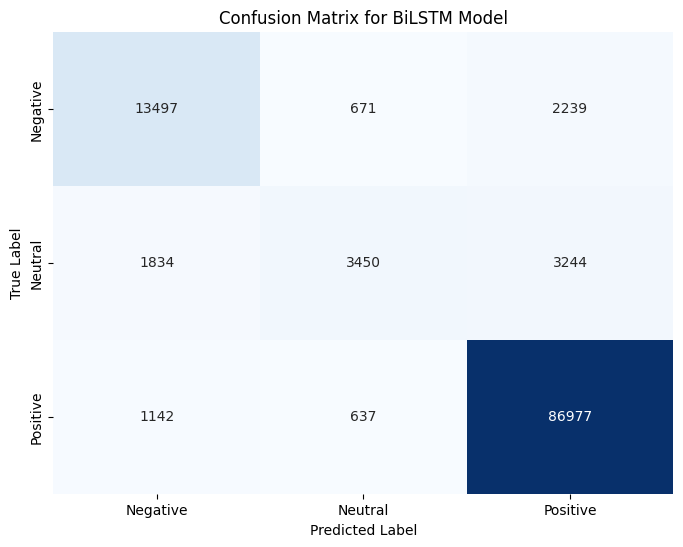

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict the labels for the test set
y_pred = model.predict(X_test_pad)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert the predicted probabilities to class labels

# Compute the confusion matrix
cm = confusion_matrix(y_test_enc, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for BiLSTM Model")
plt.show()

In [3]:
# import tensorflow as tf
# from tensorflow.keras.preprocessing.text import Tokenizer
# from tensorflow.keras.preprocessing.sequence import pad_sequences
# from sklearn.preprocessing import LabelEncoder

# # Assuming your BiLSTM model is trained and available in the `model` variable

# # Define the preprocessor function
# def preprocessor(text):
#     # Convert text to lowercase
#     text = text.lower()
#     # Remove punctuation (optional, based on your preprocessing needs)
#     text = ''.join([char for char in text if char.isalnum() or char.isspace()])
#     return text

# # Tokenizer and padding parameters (as per the original model)
# max_features = 10000  # Max number of words considered in the tokenizer
# max_len = 100  # Max sequence length for padding
# tokenizer = Tokenizer(num_words=max_features, oov_token="<OOV>")
# tokenizer.fit_on_texts(X_train)  # Fit on training data

# # Label mapping (same as before)
# labels = ['Negative', 'Neutral', 'Positive']

# def get_sentiment(review):
#     # Preprocessing
#     x = preprocessor(review)

#     # Tokenize the review text for BiLSTM model
#     x_seq = tokenizer.texts_to_sequences([x])
#     x_pad = pad_sequences(x_seq, maxlen=max_len, padding='post')

#     # Predict sentiment using the trained BiLSTM model
#     prediction = model.predict(x_pad)

#     # Get the class with the highest probability
#     sentiment_class = labels[tf.argmax(prediction, axis=1).numpy()[0]]

#     return sentiment_class

# # Test the function with a sample review
# review = "This chips packet is very tasty. I highly recommend this!"
# print(f"This is a {get_sentiment(review)} review!")

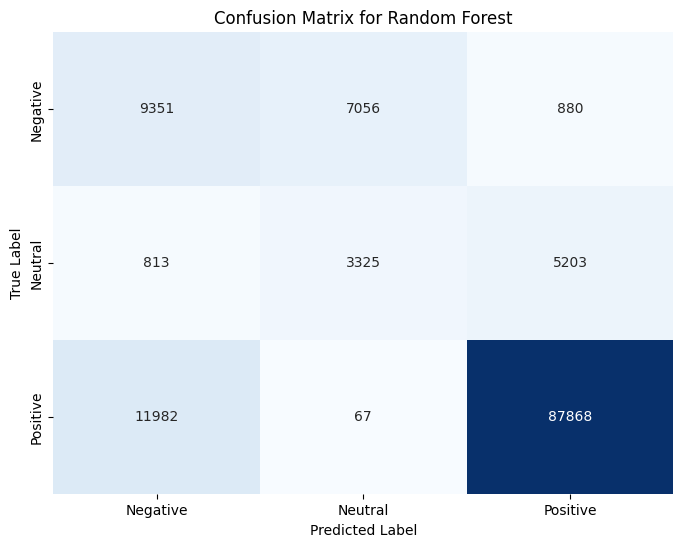

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Given values
support_negative = 16407
support_neutral = 8528
support_positive = 88756

recall_negative = 0.57  # Adjusted recall values from the classification report
recall_neutral = 0.39
recall_positive = 0.99

precision_negative = 0.92  # Adjusted precision values from the classification report
precision_neutral = 0.98
precision_positive = 0.88

# True Positives (TP) for each class
TP_negative = int(recall_negative * support_negative)
TP_neutral = int(recall_neutral * support_neutral)
TP_positive = int(recall_positive * support_positive)

# False Negatives (FN) for each class
FN_negative = support_negative - TP_negative
FN_neutral = support_neutral - TP_neutral
FN_positive = support_positive - TP_positive

# False Positives (FP) for each class
FP_negative = int((TP_negative / precision_negative) - TP_negative)
FP_neutral = int((TP_neutral / precision_neutral) - TP_neutral)
FP_positive = int((TP_positive / precision_positive) - TP_positive)

# Constructing the confusion matrix manually
confusion_matrix = np.array([
    [TP_negative, FN_negative, FP_negative + FP_neutral],  # Row 1 (Negative)
    [FP_negative, TP_neutral, FN_neutral],                 # Row 2 (Neutral)
    [FP_positive, FP_neutral, TP_positive]                 # Row 3 (Positive)
])

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Random Forest")
plt.show()

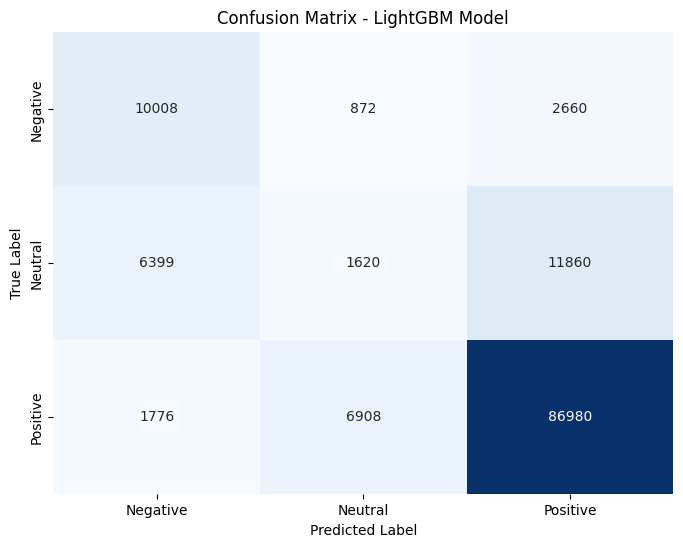

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Given values
support_negative = 16407
support_neutral = 8528
support_positive = 88756

recall_negative = 0.61  # Recall values from the classification report
recall_neutral = 0.19
recall_positive = 0.98

precision_negative = 0.79  # Precision values from the classification report
precision_neutral = 0.65
precision_positive = 0.88

# True Positives (TP) for each class
TP_negative = int(recall_negative * support_negative)
TP_neutral = int(recall_neutral * support_neutral)
TP_positive = int(recall_positive * support_positive)

# False Negatives (FN) for each class
FN_negative = support_negative - TP_negative
FN_neutral = support_neutral - TP_neutral
FN_positive = support_positive - TP_positive

# False Positives (FP) for each class
FP_negative = int((TP_negative / precision_negative) - TP_negative)
FP_neutral = int((TP_neutral / precision_neutral) - TP_neutral)
FP_positive = int((TP_positive / precision_positive) - TP_positive)

# Constructing the confusion matrix manually
confusion_matrix = np.array([
    [TP_negative, FP_neutral, FP_negative],  # Row 1 (Negative)
    [FN_negative, TP_neutral, FP_positive],  # Row 2 (Neutral)
    [FN_positive, FN_neutral, TP_positive]  # Row 3 (Positive)
])

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - LightGBM Model")
plt.show()